In [ ]:
!pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
# sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [1]:
cd /home/zhangh/medchallenge/Testing/TestingColab/detectron2

/home/zhangh/medchallenge/Testing/TestingColab/detectron2


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
torch:  1.13 ; cuda:  cu116


In [3]:
import detectron2
print(detectron2.__version__)


0.6


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Data augmentation

In [ ]:
import os
import numpy as np
import json
import cv2  # Ensure OpenCV is imported for image processing
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import detectron2.data.transforms as T
import detectron2.data.detection_utils as utils
import copy
import torch

# Define the dataset root directory
dataset_root = "/home/zhangh/medchallenge/Testing/TestingColab/dataset"

# Function to load COCO-style dataset
def get_dataset_dicts(img_dir):
    json_file = os.path.join(img_dir, "_annotations.coco.json")
    
    with open(json_file) as f:
        coco_data = json.load(f)
    
    dataset_dicts = []
    
    for image_info in coco_data['images']:
        record = {}
        record["file_name"] = os.path.join(img_dir, image_info["file_name"])
        record["height"] = image_info["height"]
        record["width"] = image_info["width"]
        record["image_id"] = image_info["id"]
        
        # Create annotations
        annotations = []
        for ann in coco_data['annotations']:
            if ann['image_id'] == image_info['id']:
                annotation = {
                    "bbox": ann["bbox"],  # [x, y, width, height]
                    "bbox_mode": BoxMode.XYWH_ABS,  # Set the correct bbox mode
                    "category_id": ann["category_id"],  # Use the category_id from your JSON
                }
                annotations.append(annotation)
        
        record["annotations"] = annotations
        dataset_dicts.append(record)
    
    return dataset_dicts

# Custom mapper for data augmentation
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # Make a copy of the dataset dictionary
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    # Define a list of augmentation transformations
    transform_list = [
        T.Resize((800, 600)),  # Resize to a consistent size
        T.RandomBrightness(0.8, 1.8),  # Randomly change brightness
        T.RandomContrast(0.6, 1.3),  # Randomly change contrast
        T.RandomSaturation(0.8, 1.4),  # Randomly change saturation
        T.RandomRotation(angle=[90, 90]),  # Randomly rotate images
        T.RandomLighting(0.7),  # Apply random lighting changes
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),  # Randomly flip images
    ]
    
    # Apply the transformations to the image
    image, transforms = T.apply_transform_gens(transform_list, image)
    
    # Convert the image to a tensor
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    # Transform the annotations based on the applied transformations
    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    
    # Convert annotations to instances
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    
    # Filter out empty instances
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    
    return dataset_dict

# Register the datasets
for d in ["train", "valid", "test"]:
    dataset_name = f"dataset_{d}"
    
    # Remove the dataset if it was already registered
    if dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(dataset_name)

    DatasetCatalog.register(
        dataset_name, 
        lambda d=d: get_dataset_dicts(os.path.join(dataset_root, d))
    )
    MetadataCatalog.get(dataset_name).set(thing_classes=["tiny-people", "dry-person", "wet-swimmer"])

# Create the configuration
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Change to a smaller model

# Update dataset names
cfg.DATASETS.TRAIN = ("dataset_train",)  # Use the registered name for the training dataset
cfg.DATASETS.TEST = ("dataset_valid",)    # Use the registered name for the validation dataset

# Set other configuration options
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Pretrained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500

# Set the number of classes based on your dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get("dataset_train").thing_classes)  # Automatically set to the number of classes

# Output directory for model checkpoints
cfg.OUTPUT_DIR = "./output"  # Specify your output directory if needed
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Initialize the trainer and start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.data_loader = build_detection_train_loader(cfg, mapper=custom_mapper)  # Set the custom data loader
trainer.train()


KeyboardInterrupt: 

# No Data Augmentation or Resizing

In [42]:
import json
from collections import defaultdict

def label_statistics(coco_json_path):
    # Load the COCO JSON file
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Initialize variables
    label_count = defaultdict(int)
    total_image_count = len(coco_data['images'])
    total_instances = 0

    # Count the occurrences of each label
    for annotation in coco_data['annotations']:
        category_id = annotation['category_id']
        category_name = coco_data['categories'][category_id]['name']
        label_count[category_name] += 1
        total_instances += 1

    # Get label information
    label_info = [{'label': label, 'count': count} for label, count in label_count.items()]

    return {
        'total_images': total_image_count,
        'total_instances': total_instances,
        'label_count': len(label_count),
        'label_info': label_info
    }

# Example usage:
coco_json_path = '/home/zhangh/medchallenge/Testing/TestingColab/dataset/NTUT 4K Drone Train_com/train/_annotations.coco.json'
statistics = label_statistics(coco_json_path)

print("Total number of images:", statistics['total_images'])
print("Total number of unique labels:", statistics['label_count'])
print("Total number of instances:", statistics['total_instances'])
print("\nLabel Information:")
for label_info in statistics['label_info']:
    print("Label:", label_info['label'])
    print("Count:", label_info['count'])
    print()


Total number of images: 446
Total number of unique labels: 1
Total number of instances: 17912

Label Information:
Label: tiny-people
Count: 17912



In [43]:
import json
from collections import defaultdict

def label_statistics(coco_json_path):
    # Load the COCO JSON file
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Initialize variables
    label_count = defaultdict(int)
    total_image_count = len(coco_data['images'])
    total_instances = 0

    # Count the occurrences of each label
    for annotation in coco_data['annotations']:
        category_id = annotation['category_id']
        category_name = coco_data['categories'][category_id]['name']
        label_count[category_name] += 1
        total_instances += 1

    # Get label information
    label_info = [{'label': label, 'count': count} for label, count in label_count.items()]

    return {
        'total_images': total_image_count,
        'total_instances': total_instances,
        'label_count': len(label_count),
        'label_info': label_info
    }

# Example usage:
coco_json_path = '/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyPerson_com/train/_annotations.coco.json'
statistics = label_statistics(coco_json_path)

print("Total number of images:", statistics['total_images'])
print("Total number of unique labels:", statistics['label_count'])
print("Total number of instances:", statistics['total_instances'])
print("\nLabel Information:")
for label_info in statistics['label_info']:
    print("Label:", label_info['label'])
    print("Count:", label_info['count'])
    print()


Total number of images: 1374
Total number of unique labels: 1
Total number of instances: 63471

Label Information:
Label: tiny-people
Count: 63471



In [94]:
import json

# Paths to the two COCO annotation files
dataset1_path = "/home/zhangh/medchallenge/Testing/TestingColab/dataset/NTUT 4K Drone Train_com/train/_annotations.coco.json"
dataset2_path = "/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyPerson_com/train/_annotations.coco.json"
output_path = "/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyNTUT/train/_annotations.coco.json"

# Load the two datasets
with open(dataset1_path, "r") as f:
    data1 = json.load(f)
with open(dataset2_path, "r") as f:
    data2 = json.load(f)

# Initialize the combined data with basic structure
combined_data = {
    "info": data1["info"],  # Copy info from one dataset, or customize as needed
    "licenses": data1["licenses"],
    "categories": [{"id": 1, "name": "tiny-people", "supercategory": "none"}],  # One category for both datasets
    "images": [],
    "annotations": []
}

# Step 1: Create new unique IDs for images
new_image_id = 0
for img in data1["images"]:
    img["id"] = new_image_id
    combined_data["images"].append(img)
    new_image_id += 1

for img in data2["images"]:
    img["id"] = new_image_id
    combined_data["images"].append(img)
    new_image_id += 1

# Step 2: Create new unique IDs for annotations and update image references
new_annotation_id = 0
for ann in data1["annotations"]:
    ann["id"] = new_annotation_id
    ann["category_id"] = 1  # Dataset1's annotations with category_id 1
    ann["image_id"] = ann["image_id"]  # No change to image_id
    combined_data["annotations"].append(ann)
    new_annotation_id += 1

# Adjust category_id for data2 to be consistent with data1 (category_id 1)
for ann in data2["annotations"]:
    ann["id"] = new_annotation_id
    ann["category_id"] = 1  # Dataset2's annotations with category_id 1
    ann["image_id"] = ann["image_id"] + len(data1["images"])  # Update image_id for dataset2
    combined_data["annotations"].append(ann)
    new_annotation_id += 1

# Step 3: Save the combined annotations to a new JSON file
with open(output_path, "w") as f:
    json.dump(combined_data, f)

print("Datasets successfully combined with a single category and unique IDs!")


Datasets successfully combined with a single category and unique IDs!


In [99]:
import json
from collections import defaultdict

def label_statistics(coco_json_path):
    # Load the COCO JSON file
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Initialize variables
    label_count = defaultdict(int)
    total_image_count = len(coco_data['images'])
    total_instances = 0

    # Count the occurrences of each label
    for annotation in coco_data['annotations']:
        category_id = annotation['category_id']
        category_name = coco_data['categories'][category_id]['name']
        label_count[category_name] += 1
        total_instances += 1

    # Get label information
    label_info = [{'label': label, 'count': count} for label, count in label_count.items()]

    return {
        'total_images': total_image_count,
        'total_instances': total_instances,
        'label_count': len(label_count),
        'label_info': label_info
    }

# Example usage:
coco_json_path = '/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyNTUT/train/_annotations.coco.json'
statistics = label_statistics(coco_json_path)

print("Total number of images:", statistics['total_images'])
print("Total number of unique labels:", statistics['label_count'])
print("Total number of instances:", statistics['total_instances'])
print("\nLabel Information:")
for label_info in statistics['label_info']:
    print("Label:", label_info['label'])
    print("Count:", label_info['count'])
    print()


Total number of images: 1820
Total number of unique labels: 1
Total number of instances: 81383

Label Information:
Label: tiny-people
Count: 81383



In [98]:
import json

# Path to the annotation file
annotation_file = "/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyNTUT/train/_annotations.coco.json"

# Load the existing COCO annotation JSON
with open(annotation_file, "r") as f:
    data = json.load(f)

# Step 1: Remap all category IDs to 0 in the annotations
for annotation in data["annotations"]:
    annotation["category_id"] = 0  # Set all to the unified category ID

# Step 2: Simplify the categories section to include only "tiny-people"
data["categories"] = [{"id": 0, "name": "tiny-people", "supercategory": "none"}]

# Step 3: Save the modified data back to the JSON file
with open(annotation_file, "w") as f:
    json.dump(data, f)

print("Annotation file successfully updated.")


Annotation file successfully updated.


In [8]:
cd /home/zhangh/medchallenge/Testing/TestingColab

/home/zhangh/medchallenge/Testing/TestingColab


In [9]:
import os
import numpy as np
import json
import cv2  # Ensure OpenCV is imported for image processing
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import detectron2.data.detection_utils as utils
import copy
import torch

In [10]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("TinyNTUT_train", {}, "/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyNTUT/train/_annotations.coco.json", "/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyNTUT/train")
register_coco_instances("TinyNTUT_val", {}, "/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyNTUT/valid/_annotations.coco.json", "/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyNTUT/valid")

from detectron2.data.datasets import register_coco_instances
register_coco_instances("TinyPerson_com_train", {}, "/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyPerson_com/train/_annotations.coco.json", "/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyPerson_com/train")
register_coco_instances("TinyPerson_com_val", {}, "/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyPerson_com/valid/_annotations.coco.json", "/home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyPerson_com/valid")

In [100]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Unregister the dataset names
DatasetCatalog.remove("TinyNTUT_train")
DatasetCatalog.remove("TinyNTUT_val")
MetadataCatalog.remove("TinyNTUT_train")
MetadataCatalog.remove("TinyNTUT_val")

# Unregister the dataset names
DatasetCatalog.remove("TinyPerson_com_train")
DatasetCatalog.remove("TinyPerson_com_val")
MetadataCatalog.remove("TinyPerson_com_train")
MetadataCatalog.remove("TinyPerson_com_val")

WARNING [11/06 12:06:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/06 12:06:02 d2.data.datasets.coco]: Loaded 1820 images in COCO format from /home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyNTUT/train/_annotations.coco.json


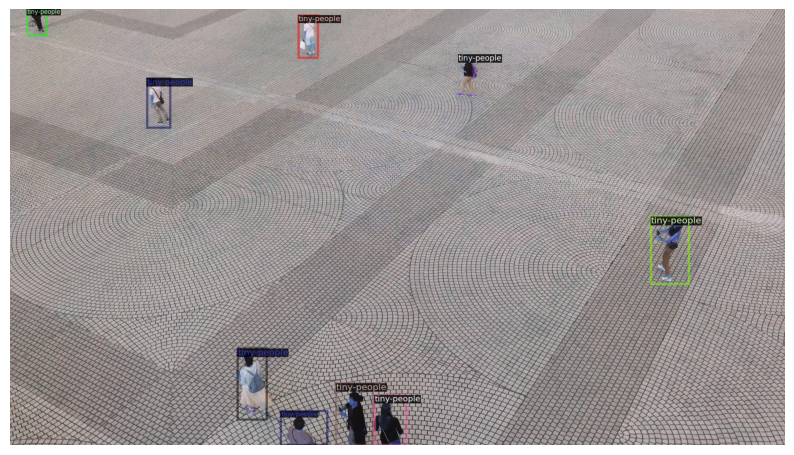

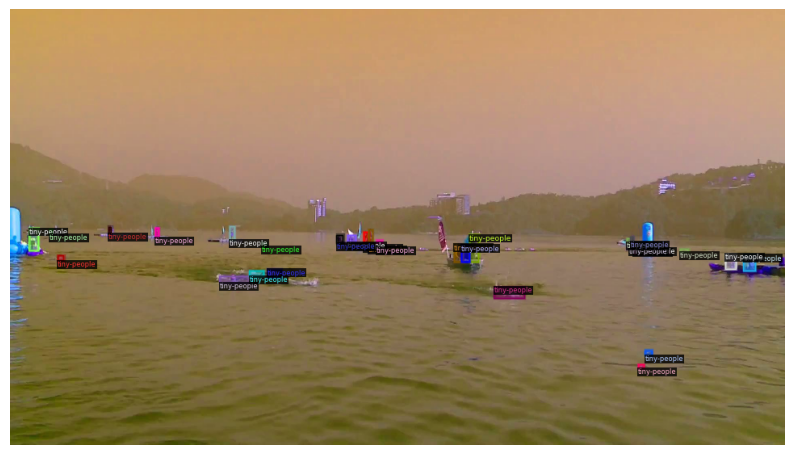

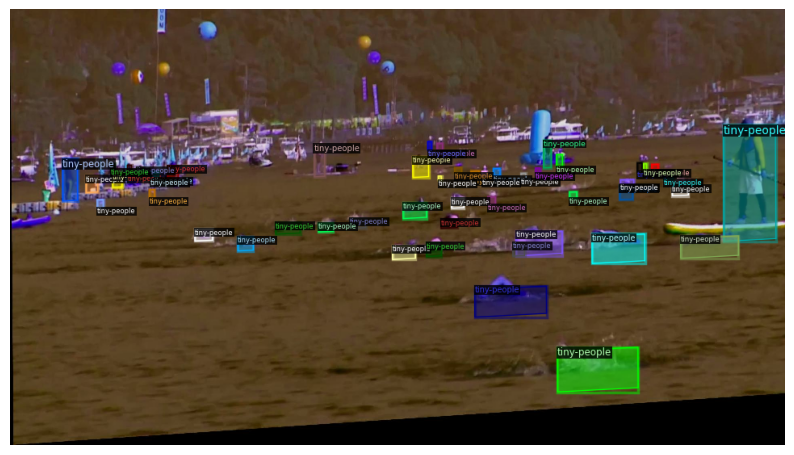

In [102]:
import random
import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

# Load your dataset dictionary and metadata
dataset_dicts = DatasetCatalog.get("TinyNTUT_train")
my_dataset_metadata = MetadataCatalog.get("TinyNTUT_train")

# Visualize a few samples
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    
    # Display the image with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()


In [6]:
!python /home/zhangh/medchallenge/Testing/TestingColab/detectron2/DiffusionDet/train_net.py --num-gpus 1 --config-file /home/zhangh/medchallenge/Testing/TestingColab/detectron2/DiffusionDet/configs/own.yaml

Command Line Args: Namespace(config_file='/home/zhangh/medchallenge/Testing/TestingColab/detectron2/DiffusionDet/configs/own.yaml', dist_url='tcp://127.0.0.1:50165', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=[], resume=False)
[11/07 08:28:10 detectron2]: Rank of current process: 0. World size: 1
[11/07 08:28:10 detectron2]: Environment info:
-------------------------------  --------------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.8.19 (default, Mar 20 2024, 19:58:24) [GCC 11.2.0]
numpy                            1.24.3
detectron2                       0.6 @/home/zhangh/medchallenge/Testing/TestingColab/detectron2/detectron2
Compiler                         GCC 11.2
CUDA compiler                    CUDA 11.8
detectron2 arch flags            7.5
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          1.13.1+cu116 @/home/zhangh/anaconda3

In [ ]:
import os
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Custom trainer with evaluator support
class TrainerWithEvaluator(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Cityscapes/mask_rcnn_R_50_FPN.yaml"))
cfg.DATASETS.TRAIN = ("TinyNTUT_train",)
cfg.DATASETS.TEST = ("TinyNTUT_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Cityscapes/mask_rcnn_R_50_FPN.yaml")
cfg.MODEL.META_ARCHITECTURE = "GeneralizedRCNN"
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.DEVICE = "cpu"


# Specify custom output directory
custom_output_dir = "/home/zhangh/medchallenge/Testing/TestingColab/output/newDataset/mask_rcnn_R_50_FPN_3x"
cfg.OUTPUT_DIR = custom_output_dir
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Save the modified configuration
with open(os.path.join(cfg.OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

# Initialize and train with evaluator
trainer = TrainerWithEvaluator(cfg)
# Check for existing checkpoint and resume if found
last_checkpoint = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
if os.path.isfile(last_checkpoint):
    cfg.MODEL.WEIGHTS = last_checkpoint  # Load from the last checkpoint if it exists
    trainer.resume_or_load(resume=True)
else:
    trainer.resume_or_load(resume=False)

# Start training
trainer.train()

[11/07 08:42:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (9, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (9,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (32, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (32,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (8, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the 

[11/07 08:42:19 d2.engine.train_loop]: Starting training from iteration 0
[11/07 08:42:20 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f5f0f27dee0> to CPU due to CUDA OOM
[11/07 08:42:21 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f5f0f27dee0> to CPU due to CUDA OOM
ERROR [11/07 08:42:21 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/zhangh/medchallenge/Testing/TestingColab/detectron2/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/home/zhangh/medchallenge/Testing/TestingColab/detectron2/detectron2/engine/defaults.py", line 530, in run_step
    self._trainer.run_step()
  File "/home/zhangh/medchallenge/Testing/TestingColab/detectron2/detectron2/engine/train_loop.py", line 322, in run_step
    losses.backward()
  File "/home/zhangh/anaconda3/envs/testing123/lib/python3.8/site-packages/torch/_tensor.py", line 488, in backward
    torch.autog

OutOfMemoryError: CUDA out of memory. Tried to allocate 114.00 MiB (GPU 0; 23.64 GiB total capacity; 2.29 GiB already allocated; 46.88 MiB free; 2.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [126]:
from detectron2.engine import DefaultPredictor
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import inference_on_dataset
import os

# Set up the configuration for inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model trained in the first half
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

# Initialize the predictor with the trained weights
predictor = DefaultPredictor(cfg)

# Initialize the evaluator for the test set
output_dir = "/home/zhangh/medchallenge/Testing/TestingColab/output/oldDataset/mask_rcnn_R_50_FPN_3x"
os.makedirs(output_dir, exist_ok=True)
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir=output_dir)

# Build the test data loader
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

# Run inference and evaluate the model
results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Print evaluation results
print(results)


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.64 GiB total capacity; 2.45 GiB already allocated; 896.00 KiB free; 2.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Normal

In [118]:
import os
import cv2
import random
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor  # Import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode

# Load your dataset and metadata
dataset_dicts = DatasetCatalog.get("TinyPerson_com_val")
my_dataset_metadata = MetadataCatalog.get("TinyPerson_com_val")

# Set up the configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Update to match the number of classes in your dataset
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # Set a custom testing threshold
predictor = DefaultPredictor(cfg)  # Initialize the predictor

# Visualize a few random samples
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    
    # Visualize predictions
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Display the image in VSCode
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()


WARNING [11/06 12:16:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/06 12:16:02 d2.data.datasets.coco]: Loaded 131 images in COCO format from /home/zhangh/medchallenge/Testing/TestingColab/dataset/TinyPerson_com/valid/_annotations.coco.json


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.64 GiB total capacity; 2.44 GiB already allocated; 2.88 MiB free; 2.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

With SAHI

In [ ]:
pip install -i https://pypi.tuna.tsinghua.edu.cn/simple sahi


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/2d/70/6f531d6074a37dd5e30b914ad5128bdcd0cb61db3d94bbf4a07c7ed5b4ec/sahi-0.11.18-py3-none-any.whl (113 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/d9/64/7fdfb9386511cd6805451e012c537073a79a958a58795c4e602e538c388c/opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0
ERROR: Cannot uninstall opencv-python 4.10.0, RECORD file not found. Hint: The package was installed by conda.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip show sahi


Name: sahi
Version: 0.11.18
Summary: A vision library for performing sliced inference on large images/small objects
Home-page: https://github.com/obss/sahi
Author: OBSS
Author-email: 
License: MIT
Location: /home/zhangh/anaconda3/envs/testing123/lib/python3.8/site-packages
Requires: click, fire, numpy, opencv-python, pillow, pybboxes, pyyaml, requests, shapely, terminaltables, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sahi import Slicer  # Import the Slicer class

# Initialize SAHI Slicer
slicer = Slicer(target_size=(640, 640))

ImportError: cannot import name 'Slicer' from 'sahi' (/home/zhangh/anaconda3/envs/testing123/lib/python3.8/site-packages/sahi/__init__.py)

In [ ]:
import sahi
print(dir(sahi))

['AutoDetectionModel', 'BoundingBox', 'Category', 'DetectionModel', 'Mask', 'ObjectPrediction', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'annotation', 'auto_model', 'models', 'prediction', 'utils']


In [128]:
import os
import cv2
import random
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
from sahi import DetectionModel
from sahi.predict import get_sliced_prediction

# Load dataset and metadata
dataset_dicts = DatasetCatalog.get("my_dataset_val")
my_dataset_metadata = MetadataCatalog.get("my_dataset_val")

# Configure Detectron2
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Adjust to your dataset's class count
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to your trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Define a custom wrapper class for the Detectron2 predictor
class CustomDetectron2Model(DetectionModel):
    def __init__(self, predictor):
        super().__init__(model_path=None)  # No model path needed for a custom predictor
        self.predictor = predictor

    def load_model(self):
        # Override to avoid NotImplementedError since we already have a model
        pass

    def perform_inference(self, image):
        outputs = self.predictor(image)
        return outputs["instances"].to("cpu")

    def convert_original_predictions(self, predictions, image_size, shift_amount=[0, 0], full_shape=None):
        # Extract relevant information from Detectron2 predictions
        boxes = predictions.pred_boxes.tensor.numpy()
        scores = predictions.scores.numpy()
        labels = predictions.pred_classes.numpy()

        # Adjust bounding boxes based on shift_amount for tiled predictions
        boxes[:, [0, 2]] += shift_amount[1]  # Adjust x-coordinates
        boxes[:, [1, 3]] += shift_amount[0]  # Adjust y-coordinates
        
        # Return in the format expected by SAHI
        return boxes, scores, labels


# Initialize the custom model for SAHI
sahi_model = CustomDetectron2Model(predictor=predictor)

# Visualize sliced predictions
for d in random.sample(dataset_dicts, 3):
    image_path = d["file_name"]
    image = cv2.imread(image_path)
    
    # Get sliced prediction using SAHI
    result = get_sliced_prediction(
        image=image,
        detection_model=sahi_model,
        slice_height=640,  # Define height of each tile
        slice_width=640,   # Define width of each tile
        overlap_height_ratio=0.2,  # Optional: overlap for smoother merging
        overlap_width_ratio=0.2
    )
    
    # Display the result image with bounding boxes
    result_image = result.image_with_boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.axis("off")
    plt.show()


KeyError: "Dataset 'my_dataset_val' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val, TinyNTUT_train, TinyNTUT_val, TinyPerson_com_train, TinyPerson_com_val"

# Stop

In [ ]:
import os
import numpy as np
import json
import cv2  # Ensure OpenCV is imported for image processing
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import detectron2.data.detection_utils as utils
import copy
import torch

# Define the dataset root directory
dataset_root = "/home/zhangh/medchallenge/Testing/TestingColab/dataset"

# Function to load COCO-style dataset
def get_dataset_dicts(img_dir):
    json_file = os.path.join(img_dir, "_annotations.coco.json")
    
    with open(json_file) as f:
        coco_data = json.load(f)
    
    dataset_dicts = []
    
    for image_info in coco_data['images']:
        record = {}
        record["file_name"] = os.path.join(img_dir, image_info["file_name"])
        record["height"] = image_info["height"]
        record["width"] = image_info["width"]
        record["image_id"] = image_info["id"]
        
        # Create annotations
        annotations = []
        for ann in coco_data['annotations']:
            if ann['image_id'] == image_info['id']:
                annotation = {
                    "bbox": ann["bbox"],  # [x, y, width, height]
                    "bbox_mode": BoxMode.XYWH_ABS,  # Set the correct bbox mode
                    "category_id": ann["category_id"],  # Use the category_id from your JSON
                }
                annotations.append(annotation)
        
        record["annotations"] = annotations
        dataset_dicts.append(record)
    
    return dataset_dicts

# Custom mapper without data augmentation or resizing
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # Make a copy of the dataset dictionary
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    # Convert the image to a tensor without resizing
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    # Transform the annotations based on the applied transformations
    annos = [
        utils.transform_instance_annotations(obj, [], image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    
    # Convert annotations to instances
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    
    # Filter out empty instances
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    
    return dataset_dict

# Register the datasets
for d in ["train", "valid", "test"]:
    dataset_name = f"dataset_{d}"
    
    # Remove the dataset if it was already registered
    if dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(dataset_name)

    DatasetCatalog.register(
        dataset_name, 
        lambda d=d: get_dataset_dicts(os.path.join(dataset_root, d))
    )
    MetadataCatalog.get(dataset_name).set(thing_classes=["tiny-people", "dry-person", "wet-swimmer"])

# Create the configuration
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Change to a smaller model

# Update dataset names
cfg.DATASETS.TRAIN = ("dataset_train", "dataset_valid")  # Use the registered name for the training dataset
cfg.DATASETS.TEST = ("dataset_test",)    # Use the registered name for the validation dataset

# Set other configuration options
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Pretrained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500

# Set the number of classes based on your dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get("dataset_train").thing_classes)  # Automatically set to the number of classes

# Output directory for model checkpoints
cfg.OUTPUT_DIR = "./output"  # Specify your output directory if needed
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# # Create the configuration
# cfg = get_cfg()
# cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Change to a smaller model

# # Update dataset names
# cfg.DATASETS.TRAIN = ("dataset_train",)  # Use the registered name for the training dataset
# cfg.DATASETS.TEST = ("dataset_valid",)    # Use the registered name for the validation dataset

# # Set other configuration options
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Pretrained weights
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.0001  # Lower learning rate for stability
# cfg.SOLVER.MAX_ITER = 2000  # Increased iterations for better convergence with small objects

# # Adjust proposal limits for more small-object proposals
# cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 2000
# cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 1000
# cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 1000
# cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 500

# # Increase detections per image to capture more objects
# cfg.TEST.DETECTIONS_PER_IMAGE = 200

# # Set anchor sizes for small object detection
# cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32]]
# cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0]]

# # Set the number of classes based on your dataset
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get("dataset_train").thing_classes)  # Automatically set to the number of classes

# # Output directory for model checkpoints
# cfg.OUTPUT_DIR = "./output"
# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Initialize the trainer and start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.data_loader = build_detection_train_loader(cfg, mapper=custom_mapper)  # Set the custom data loader
trainer.train()


[10/30 13:33:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[10/30 13:33:37 d2.data.build]: Removed 3 images with no usable annotations. 1502 images left.
[10/30 13:33:37 d2.data.build]: Using training sampler TrainingSampler
[10/30 13:33:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/30 13:33:37 d2.data.common]: Serializing 1502 elements to byte tensors and concatenating them all ...
[10/30 13:33:37 d2.data.common]: Serialized dataset takes 3.10 MiB
[10/30 13:33:37 d2.data.build]: Making batched data loader with batch_size=2
[10/30 13:33:37 d2.engine.train_loop]: Starting training from iteration 0
[10/30 13:33:46 d2.utils.events]:  eta: 0:03:13  iter: 19  total_loss: 2.479  loss_cls: 1.358  loss_box_reg: 0.1635  loss_rpn_cls: 0.4414  loss_rpn_loc: 0.3437    time: 0.4226  last_time: 0.4179  data_time: 0.0243  last_data_time: 0.0141   lr: 9.7405e-06  max_mem: 22553M
[10/30 13:33:54 d2.utils.events]:  eta: 0:03:04  iter: 39  total_loss: 2.062  loss_cls: 1.235  loss_box_reg: 0.1934  los

[10/30 13:34:51 d2.utils.events]:  eta: 0:02:09  iter: 179  total_loss: 1.022  loss_cls: 0.4261  loss_box_reg: 0.169  loss_rpn_cls: 0.14  loss_rpn_loc: 0.3915    time: 0.4094  last_time: 0.4293  data_time: 0.0174  last_data_time: 0.0252   lr: 8.966e-05  max_mem: 22553M
[10/30 13:34:59 d2.utils.events]:  eta: 0:02:01  iter: 199  total_loss: 0.908  loss_cls: 0.3376  loss_box_reg: 0.09978  loss_rpn_cls: 0.1087  loss_rpn_loc: 0.3436    time: 0.4108  last_time: 0.4116  data_time: 0.0195  last_data_time: 0.0138   lr: 9.9651e-05  max_mem: 22553M
[10/30 13:35:08 d2.utils.events]:  eta: 0:01:53  iter: 219  total_loss: 1.006  loss_cls: 0.3921  loss_box_reg: 0.1515  loss_rpn_cls: 0.123  loss_rpn_loc: 0.296    time: 0.4113  last_time: 0.4064  data_time: 0.0206  last_data_time: 0.0254   lr: 0.00010964  max_mem: 22553M
[10/30 13:35:16 d2.utils.events]:  eta: 0:01:45  iter: 239  total_loss: 0.8075  loss_cls: 0.2942  loss_box_reg: 0.09912  loss_rpn_cls: 0.1326  loss_rpn_loc: 0.2871    time: 0.4126  la

In [ ]:
# cfg.DATASETS.TRAIN = ("dataset_train",)  # Use the training dataset
# cfg.DATASETS.VAL = ("dataset_valid",)     # Use the validation dataset
# cfg.DATASETS.TEST = ("dataset_test",)     # Use the test dataset

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # set the testing threshold for this model
cfg.DATASETS.TEST = ("dataset_val", )
predictor = DefaultPredictor(cfg)

[10/30 13:38:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Create evaluator for your validation dataset
evaluator = COCOEvaluator("dataset_valid", ("bbox",), False, output_dir="./output/")  # Change "dataset_valid" if your dataset is named differently
val_loader = build_detection_test_loader(cfg, "dataset_valid")  # Ensure the dataset name matches

# Perform inference and print the results
results = inference_on_dataset(trainer.model, val_loader, evaluator)
print(results)

# Another equivalent way to evaluate the model is to use `trainer.test`
# results = trainer.test(cfg, evaluator=evaluator)


[10/30 13:49:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/30 13:49:31 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/30 13:49:31 d2.data.common]: Serializing 131 elements to byte tensors and concatenating them all ...
[10/30 13:49:31 d2.data.common]: Serialized dataset takes 0.21 MiB
[10/30 13:49:31 d2.evaluation.evaluator]: Start inference on 131 batches
[10/30 13:49:32 d2.evaluation.evaluator]: Inference done 11/131. Dataloading: 0.0054 s/iter. Inference: 0.0441 s/iter. Eval: 0.0004 s/iter. Total: 0.0499 s/iter. ETA=0:00:05
[10/30 13:49:37 d2.evaluation.evaluator]: Inference done 112/131. Dataloading: 0.0056 s/iter. Inference: 0.0436 s/iter. Eval: 0.0004 s/iter. Total: 0.0497 s/iter. ETA=0:00:00
[10/30 13:49:38 d2.evaluation.evaluator]: Total inference time: 0:00:06.310322 (0.050082 s / iter per device,

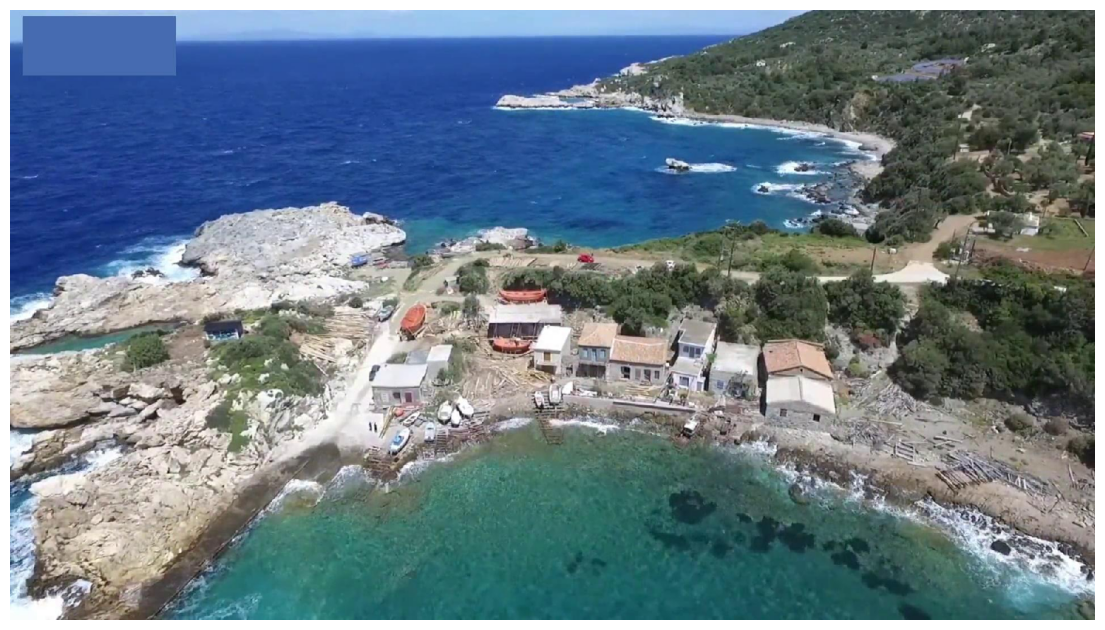

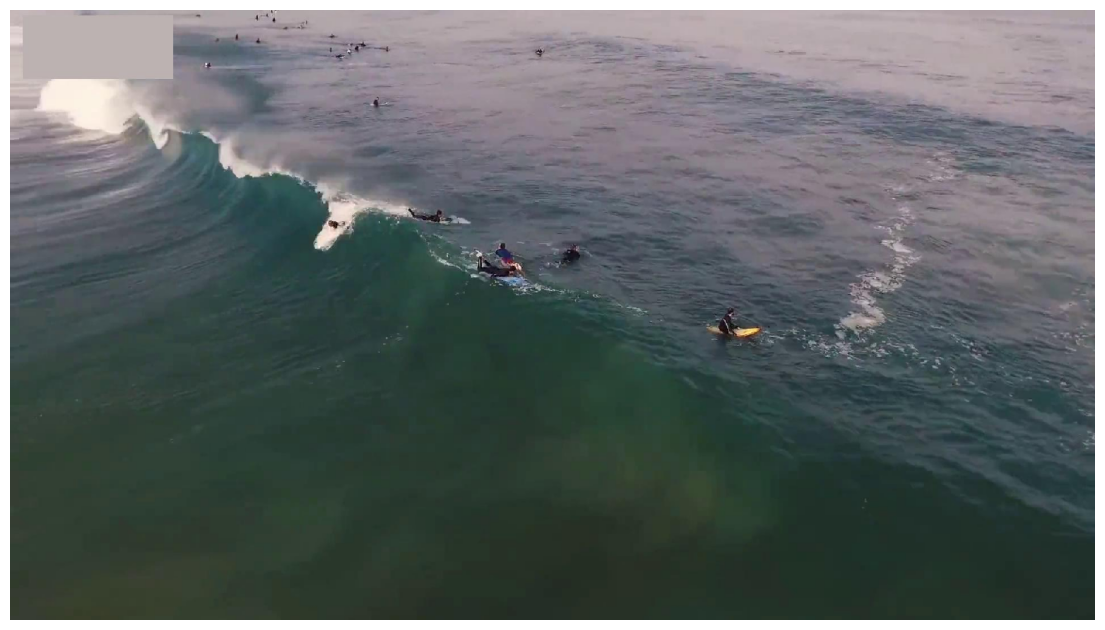

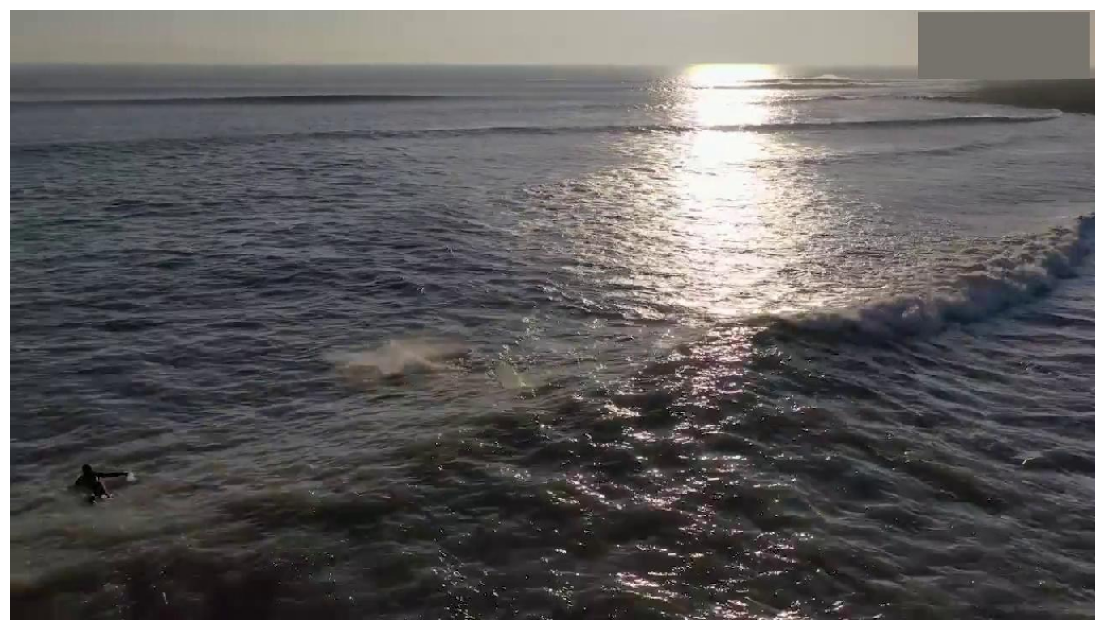

In [ ]:
from detectron2.utils.visualizer import ColorMode
import random

# Load your dataset dictionary
dataset_dicts = get_dataset_dicts("/home/zhangh/medchallenge/Testing/TestingColab/dataset/valid")  # Change the path accordingly

# Replace with your specific metadata
metadata = MetadataCatalog.get("dataset_valid")  # Ensure this matches your registered dataset name

# Sample 3 random images from the dataset
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])  # Read the image
    outputs = predictor(im)  # Get the predictions from your model
    
    # Visualize the predictions
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Display the image
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()

# Inference Slicer

In [ ]:
!pip install supervision -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 2.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 56.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.5/746.5 kB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 47.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of

[10/30 10:47:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/zhangh/medchallenge/Testing/TestingColab/output/model_final.pth ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (81, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (81,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (12, 1024) in the checkpoint but (320, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (320,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

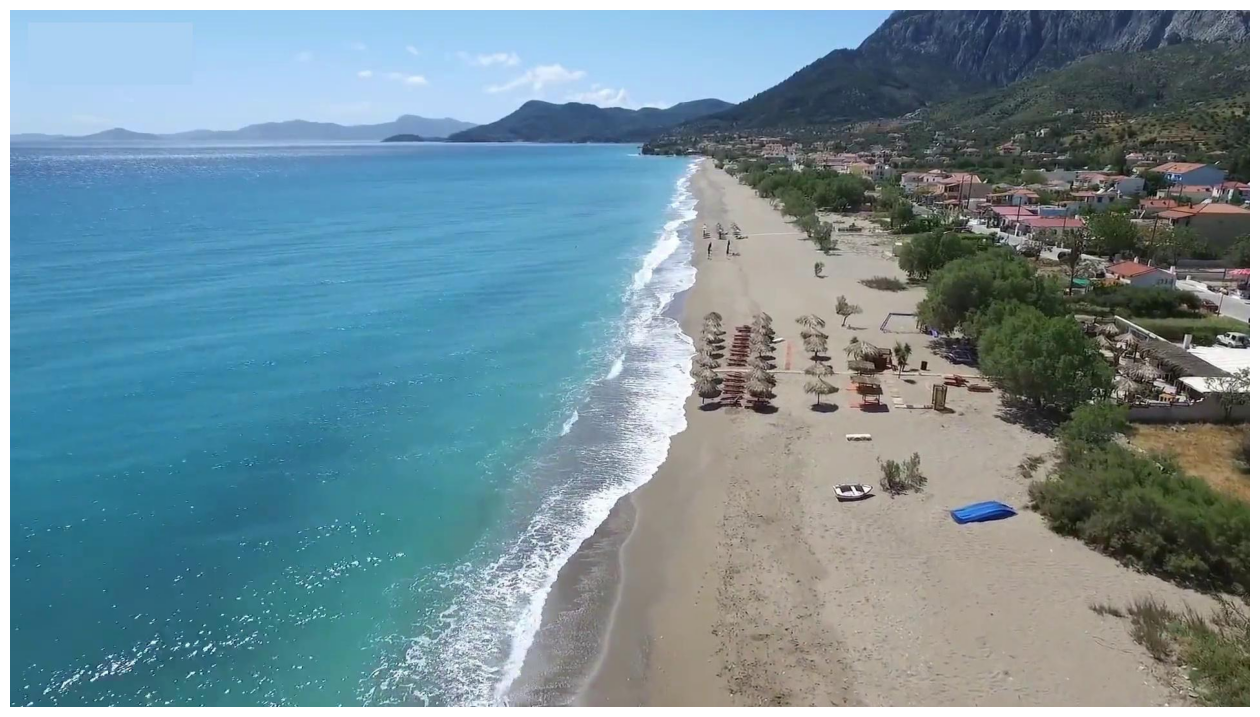

: 

In [ ]:
import os
import cv2
import supervision as sv
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

# Define the paths based on your earlier code
dataset_root = "/home/zhangh/medchallenge/Testing/TestingColab/dataset"
image_path = os.path.join(dataset_root, "test", "bb_V0005_I0001640_jpg.rf.012502ae69b3c26f7fea0a4181dd7485.jpg")  # Replace with your actual image filename

# Load the source image
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Configure the Detectron2 model
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Path to the model config
cfg.MODEL.WEIGHTS = "/home/zhangh/medchallenge/Testing/TestingColab/output/model_final.pth"  # Correct weights path
predictor = DefaultPredictor(cfg)

# Define a callback function for inference slicing
def callback(slice_image):
    """
    Callback function that runs the predictor on the sliced image.

    Args:
        slice_image (ndarray): The image slice to predict.

    Returns:
        sv.Detections: The detections from the predictor.
    """
    result = predictor(slice_image)
    return sv.Detections.from_detectron2(result)

# Initialize the Inference Slicer
slicer = sv.InferenceSlicer(callback=callback)

# Perform inference slicing
sliced_detections = slicer(image=image)

# Get the number of predictions
prediction_num = len(sliced_detections.xyxy)

# Create a box annotator to annotate detections on the image
box_annotator = sv.BoxAnnotator()

# Annotate the image with detections
annotated_frame = box_annotator.annotate(
    scene=image.copy(),
    detections=sliced_detections  # Use the sliced detections without labels
)

# Display the annotated image
sv.plot_image(image=annotated_frame, size=(16, 16))

# Alternatively, if the plotting doesn't work, use OpenCV to display the image
cv2.imshow("Annotated Frame", annotated_frame)
cv2.waitKey(0)  # Wait until a key is pressed
cv2.destroyAllWindows()  # Close the window

